https://arxiv.org/abs/1802.10174

https://cedric.cnam.fr/~soutif/QKP/QKP.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
import cvxpy as cp

In [2]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [160]:
with open('jeu_100_50_5.txt', 'r') as f:
    lines = f.read().split('\n')

In [161]:
dim = int(lines[1])
diag = np.array([int(x) for x in lines[2].split()])

In [162]:
off_diag = []

for i in range(3, dim + 3 - 1):
    off_diag.append(np.array([int(x) for x in lines[i].split()]))

In [163]:
constraint_type = int(lines[dim + 3])
# 0 if the constraint is of type <= (i.e. always since we are considering (QKP) instances)
# and 1 if the constraint is an eglity constraint
print(constraint_type) 

0


In [164]:
capacity = int(lines[dim + 3 + 1])
capacity

2536

In [165]:
weights = np.array([int(x) for x in lines[dim + 3 + 2].split()])

In [166]:
A = np.zeros((dim, dim))
for i in range(dim):
    A[i, i] = diag[i]
    if i < dim - 1:
        A[i, i+1:] = off_diag[i]
        
# A = np.eye(dim)

In [167]:
A_torch = torch.tensor(A, dtype=torch.float64)
weights_torch = torch.tensor(weights, dtype=torch.float64) / capacity

In [168]:
potential = lambda x: -torch.einsum('ni,ij,nj->n', x, A_torch, x)
isvalid = lambda x: (x @ weights_torch <= 1)

def regularized_potential(x):
    with torch.no_grad():
        a, _ = torch.max(x, axis=-1)
    
    exp_x = torch.exp(x - a[:, None])
    
    z = exp_x / (torch.exp(-a) + exp_x @ weights_torch)[:, None]
    # z = torch.exp(x - a[:, None] - torch.log(torch.exp(-a) + exp_x @ weights_torch)[:, None])
    with torch.no_grad():
        mask = torch.round(z).to(torch.float64)
        # mask = isvalid(torch.round(z)).to(torch.float64)
    
    vals = potential(z) - (x).sum(axis=-1) \
                + (dim + 1) * torch.log(torch.exp(-a) + exp_x @ weights_torch)
    return vals

In [169]:
num_particles = 10
particles = np.random.randn(*(num_particles, dim)) * 0.1
particles = torch.tensor(-particles, dtype=torch.float64, requires_grad=True)
h = 0.01
counter = 2

In [170]:
# particles

In [171]:
a, _ = torch.max(particles, axis=-1)
exp_x = torch.exp(particles - a[:, None])
z = exp_x / (torch.exp(-a) + exp_x @ weights_torch)[:, None]

In [172]:
z @ weights_torch

tensor([0.5184, 0.5202, 0.5165, 0.5121, 0.5153, 0.5166, 0.5173, 0.5160, 0.5219,
        0.5201], dtype=torch.float64, grad_fn=<MvBackward0>)

In [173]:
C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [174]:
capacity

2536

In [175]:
weights_torch.min()

tensor(0.0012, dtype=torch.float64)

In [176]:
torch.sigmoid(particles) @ weights_torch

tensor([0.5352, 0.5372, 0.5332, 0.5284, 0.5321, 0.5336, 0.5340, 0.5332, 0.5391,
        0.5371], dtype=torch.float64, grad_fn=<MvBackward0>)

In [177]:
best_val = np.inf
best_particle = None

num_iters = 10_000

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)

for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 1 * np.sin(i / 2000) ** 2 + 1
    with torch.no_grad():
        # C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        # sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        # particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        torch.clip(particles, min=-2, max=2, out=particles)
        
        z = torch.sigmoid(particles)
        rounded_z = torch.round(z)
        mask = isvalid(rounded_z)
        
        if mask.sum() > 0:
            rounded_vals = potential(rounded_z[mask])
            rounded_history[i] = rounded_vals.min()
        else:
            rounded_history[i] = best_val
        
        history[i] = vals.min()
        C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = particles[mask][jj].detach().clone()
            best_val = rounded_history[i]
    
    counter += 1
    particles.grad.zero_()

In [178]:
# 18558.00
# 56525.00
# 3752.00
# 50382.00
# 61494.00

In [179]:
history.min()

tensor(-100178.9287, dtype=torch.float64)

In [180]:
capacity

2536

In [181]:
best_particle = best_particle.reshape(1, -1)
a, _ = torch.max(best_particle, axis=-1)

exp_x = torch.exp((best_particle) - a[:, None])
z = exp_x / (torch.exp(-a) + exp_x @ weights_torch)[:, None]

In [182]:
torch.round(z) @ weights_torch

tensor([0.8387], dtype=torch.float64)

In [183]:
z @ weights_torch

tensor([0.7840], dtype=torch.float64)

In [184]:
potential(torch.round(z).reshape(1, -1))

tensor([-87961.], dtype=torch.float64)

In [185]:
capacity

2536

In [186]:
torch.round(z).detach().numpy() @ weights 

array([2127.])

In [187]:
A.shape

(100, 100)

In [188]:
z_temp = torch.round(z).detach().numpy()
z_temp @ A @ z_temp.T

array([[87961.]])

In [189]:
z_temp

array([[0., 0., 2., 1., 2., 0., 2., 1., 0., 0., 2., 1., 0., 2., 0., 0.,
        2., 1., 0., 1., 2., 1., 1., 2., 2., 1., 1., 2., 2., 2., 0., 1.,
        2., 2., 2., 1., 0., 1., 1., 2., 1., 2., 0., 1., 2., 2., 0., 1.,
        1., 0., 1., 1., 0., 2., 2., 2., 0., 2., 1., 2., 0., 2., 2., 0.,
        1., 0., 0., 1., 2., 2., 0., 1., 1., 1., 1., 1., 0., 1., 1., 2.,
        1., 0., 2., 0., 0., 1., 0., 2., 1., 1., 2., 2., 1., 1., 1., 0.,
        2., 2., 2., 0.]])

In [87]:
torch.sigmoid(particles) @ weights_torch

tensor([0.2415, 0.2403, 0.2536, 0.2619, 0.2387, 0.2333, 0.2372, 0.2450, 0.2338,
        0.2563], dtype=torch.float64, grad_fn=<MvBackward0>)

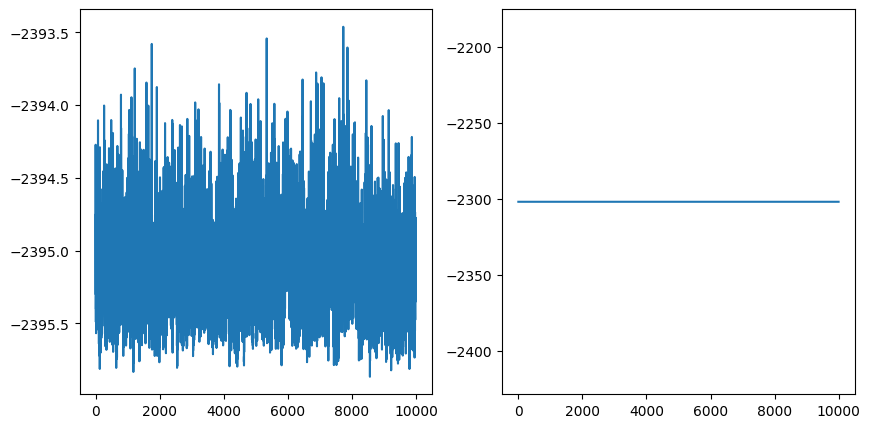

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history)
axs[1].plot(rounded_history)

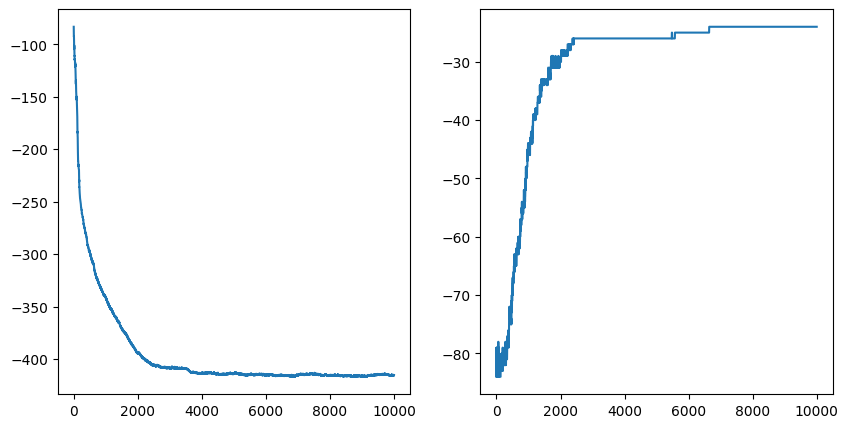

In [65]:
# 18558.00
# 56525.00
# 3752.00
# 50382.00
# 61494.00

history.min()

capacity

z = torch.round(torch.sigmoid(best_particle))
z @ weights_torch

potential(z.reshape(1, -1))

torch.sigmoid(particles) @ weights_torch

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [902]:
A_torch = torch.tensor(A, dtype=torch.float64)
weights_torch = torch.tensor(weights, dtype=torch.float64)

In [903]:
potential = lambda x: -torch.einsum('ni,ij,nj->n', x, A_torch, x)
isvalid = lambda x: (x @ weights_torch <= capacity) * (x >= 0).all(axis=-1)

def regularized_potential(x):
    z = torch.sigmoid(particles)
    with torch.no_grad():
        mask = torch.round(z).to(torch.float64)
        # mask = isvalid(torch.round(z)).to(torch.float64)
    
    vals = potential(z) + torch.log(2 * (1 + torch.cosh(x))).sum(axis=-1)
    # return mask * vals \
    #         + 0.1 * (1 - mask) * (torch.max(torch.tensor(0), z @ weights_torch - capacity)) ** 2
    return vals + 100 * (torch.max(torch.tensor(0), z @ weights_torch - capacity)) ** 2

In [904]:
num_particles = 10
particles = np.random.rand(*(num_particles, dim))
particles = torch.tensor(-particles - 5, dtype=torch.float64, requires_grad=True)
h = 0.01
counter = 2

In [905]:
C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [906]:
capacity

2298

In [907]:
torch.sigmoid(particles) @ weights_torch

tensor([12.9097, 13.0072, 13.1605, 12.8869, 13.1521, 12.8711, 12.4549, 13.2988,
        13.1090, 13.4570], dtype=torch.float64, grad_fn=<MvBackward0>)

In [916]:
best_val = np.inf
best_particle = None

num_iters = 10_000

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)

for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 1 * np.sin(i / 2000) ** 2 + 10
    with torch.no_grad():
        # C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        # sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        # particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        torch.clip(particles, min=-10, max=10, out=particles)
        
        z = torch.sigmoid(particles)
        rounded_z = torch.round(z)
        mask = isvalid(rounded_z)
        
        if mask.sum() > 0:
            rounded_vals = potential(rounded_z[mask])
            rounded_history[i] = rounded_vals.min()
        else:
            rounded_history[i] = best_val
        
        history[i] = vals.min()
        C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = particles[mask][jj].detach().clone()
            best_val = rounded_history[i]
    
    counter += 1
    particles.grad.zero_()

In [917]:
# 18558.00
# 56525.00
# 3752.00
# 50382.00
# 61494.00

In [918]:
history.min()

tensor(-48079.8665, dtype=torch.float64)

In [919]:
capacity

2298

In [920]:
z = torch.round(torch.sigmoid(best_particle))
z @ weights_torch

tensor(2292., dtype=torch.float64)

In [921]:
potential(z.reshape(1, -1))

tensor([-48613.], dtype=torch.float64)

In [922]:
torch.sigmoid(particles) @ weights_torch

tensor([2287.3742, 2289.8015, 2288.4208, 2293.0957, 2298.2985, 2298.2066,
        2290.9999, 2291.8790, 2293.0005, 2292.0239], dtype=torch.float64,
       grad_fn=<MvBackward0>)

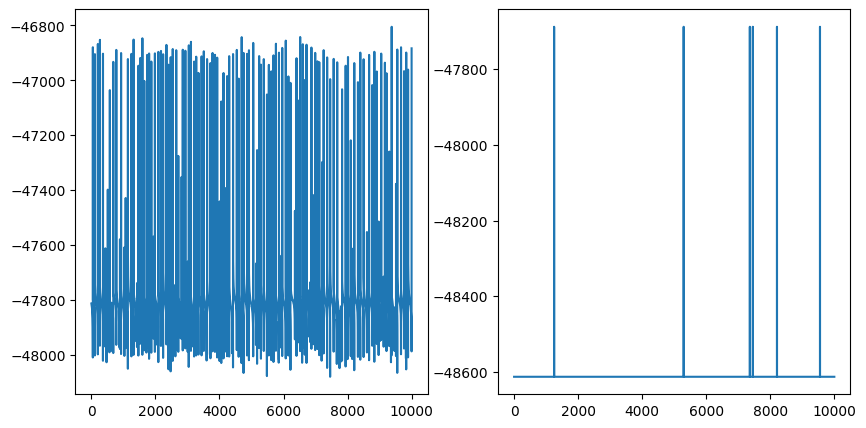

In [923]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history)
axs[1].plot(rounded_history)